In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
import scipy
from scipy.integrate import cumtrapz
import seaborn as sns
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import arviz as az

import chart_studio.plotly as py
import chart_studio
import json

import rpgf2lib

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
category_df = pd.read_csv('../data/project2cat.csv')
category_df.rename(columns={'name': 'project'}, inplace=True)
category_df = category_df[['project', 'impactCategory']]
category_df.loc[category_df['impactCategory'] == 'COMMUNITY_EDUCATION', 'impactCategory'] = 'Edu & Outreach'
category_df.loc[category_df['impactCategory'] == 'TOOLING', 'impactCategory'] = 'Tooling & Utilities'
category_df.loc[category_df['impactCategory'] == 'GOVERNANCE', 'impactCategory'] = 'Governance'
category_df.loc[category_df['impactCategory'] == 'INFRASTRUCTURE', 'impactCategory'] = 'Infra & Deps'
category_df.loc[category_df['impactCategory'] == 'RESEARCH_AND_DEVELOPMENT', 'impactCategory'] = 'Protocol R&D'
category_df.loc[category_df['impactCategory'] == 'END_USER_EXPERIENCE', 'impactCategory'] = 'Product & UX'

df = pd.read_csv('../data/final_votes_anonymized.csv')

cols = ['voterId', 'project', 'projectId', 'amount']
dff = df[cols]
# add category column
dff = dff.merge(category_df, on='project', how='left')
dff.rename(columns={'impactCategory': 'category'}, inplace=True)

# add category to df
df['category'] = df['project'].map(category_df.set_index('project')['impactCategory'])


projectid2name = {}
projectname2id = {}
for i, row in dff.iterrows():
    projectid2name[row['projectId']] = row['project']
    projectname2id[row['project']] = row['projectId']

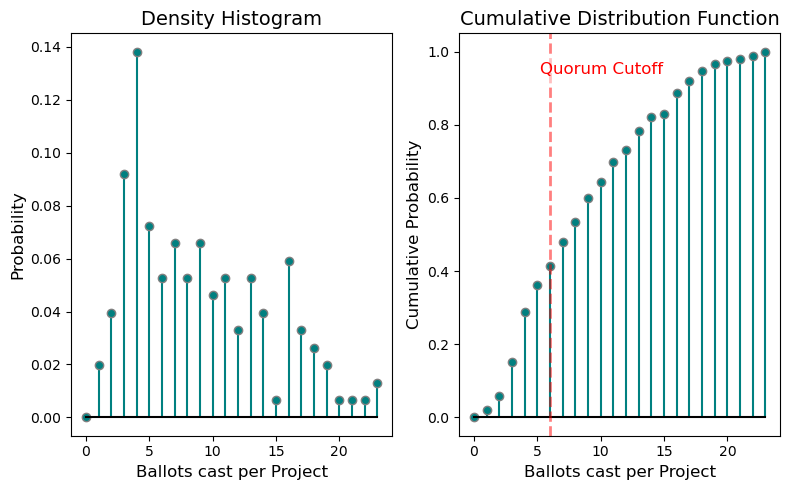

In [4]:
rpgf2lib.votes_distribution_stem(dff, quorum_cutoff=6, save_fp='../figures/votes_distribution.png')

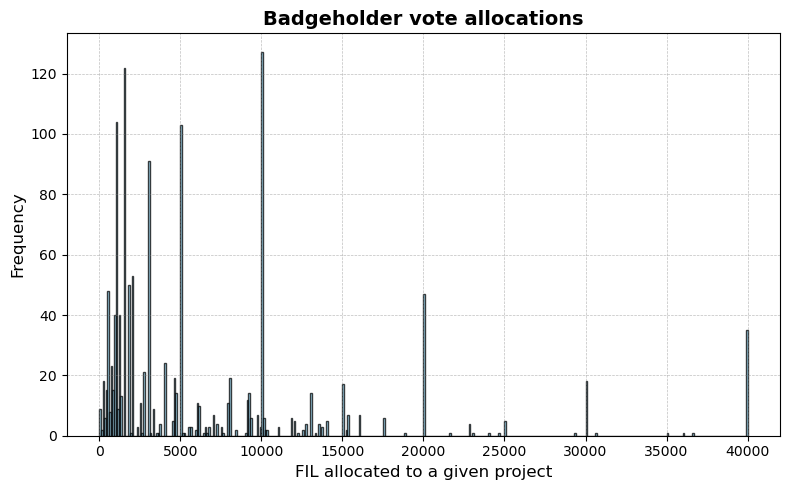

In [5]:
rpgf2lib.votes_per_project_histogram(dff, save_fp='../figures/votes_per_project.png')

In [6]:
dff['amount'].value_counts()

10000.00000    127
1000.00000     104
5000.00000     103
1525.00000      80
2000.00000      53
              ... 
277.00000        1
24696.81398      1
21644.39877      1
18869.47585      1
6477.00000       1
Name: amount, Length: 130, dtype: int64

In [7]:
allocations, eliminated, reasons, stats, failed_df, success_df = rpgf2lib.run_allocation_analysis(
    df,
    quorum_cutoff=6,
    min_funding=150,
    total_funding=270300,
    project_names=projectid2name,
    verbose=False
)

In [8]:
print(f'Failed {len(failed_df)} projects')
print(f'Success {len(success_df)} projects')
print(f'Total {len(df.groupby("projectId").size())} projects')

Failed 55 projects
Success 97 projects
Total 152 projects


In [9]:
failed_df.to_csv('../data/failed_projects.csv', index=False)
success_df.to_csv('../data/successful_projects.csv', index=False)

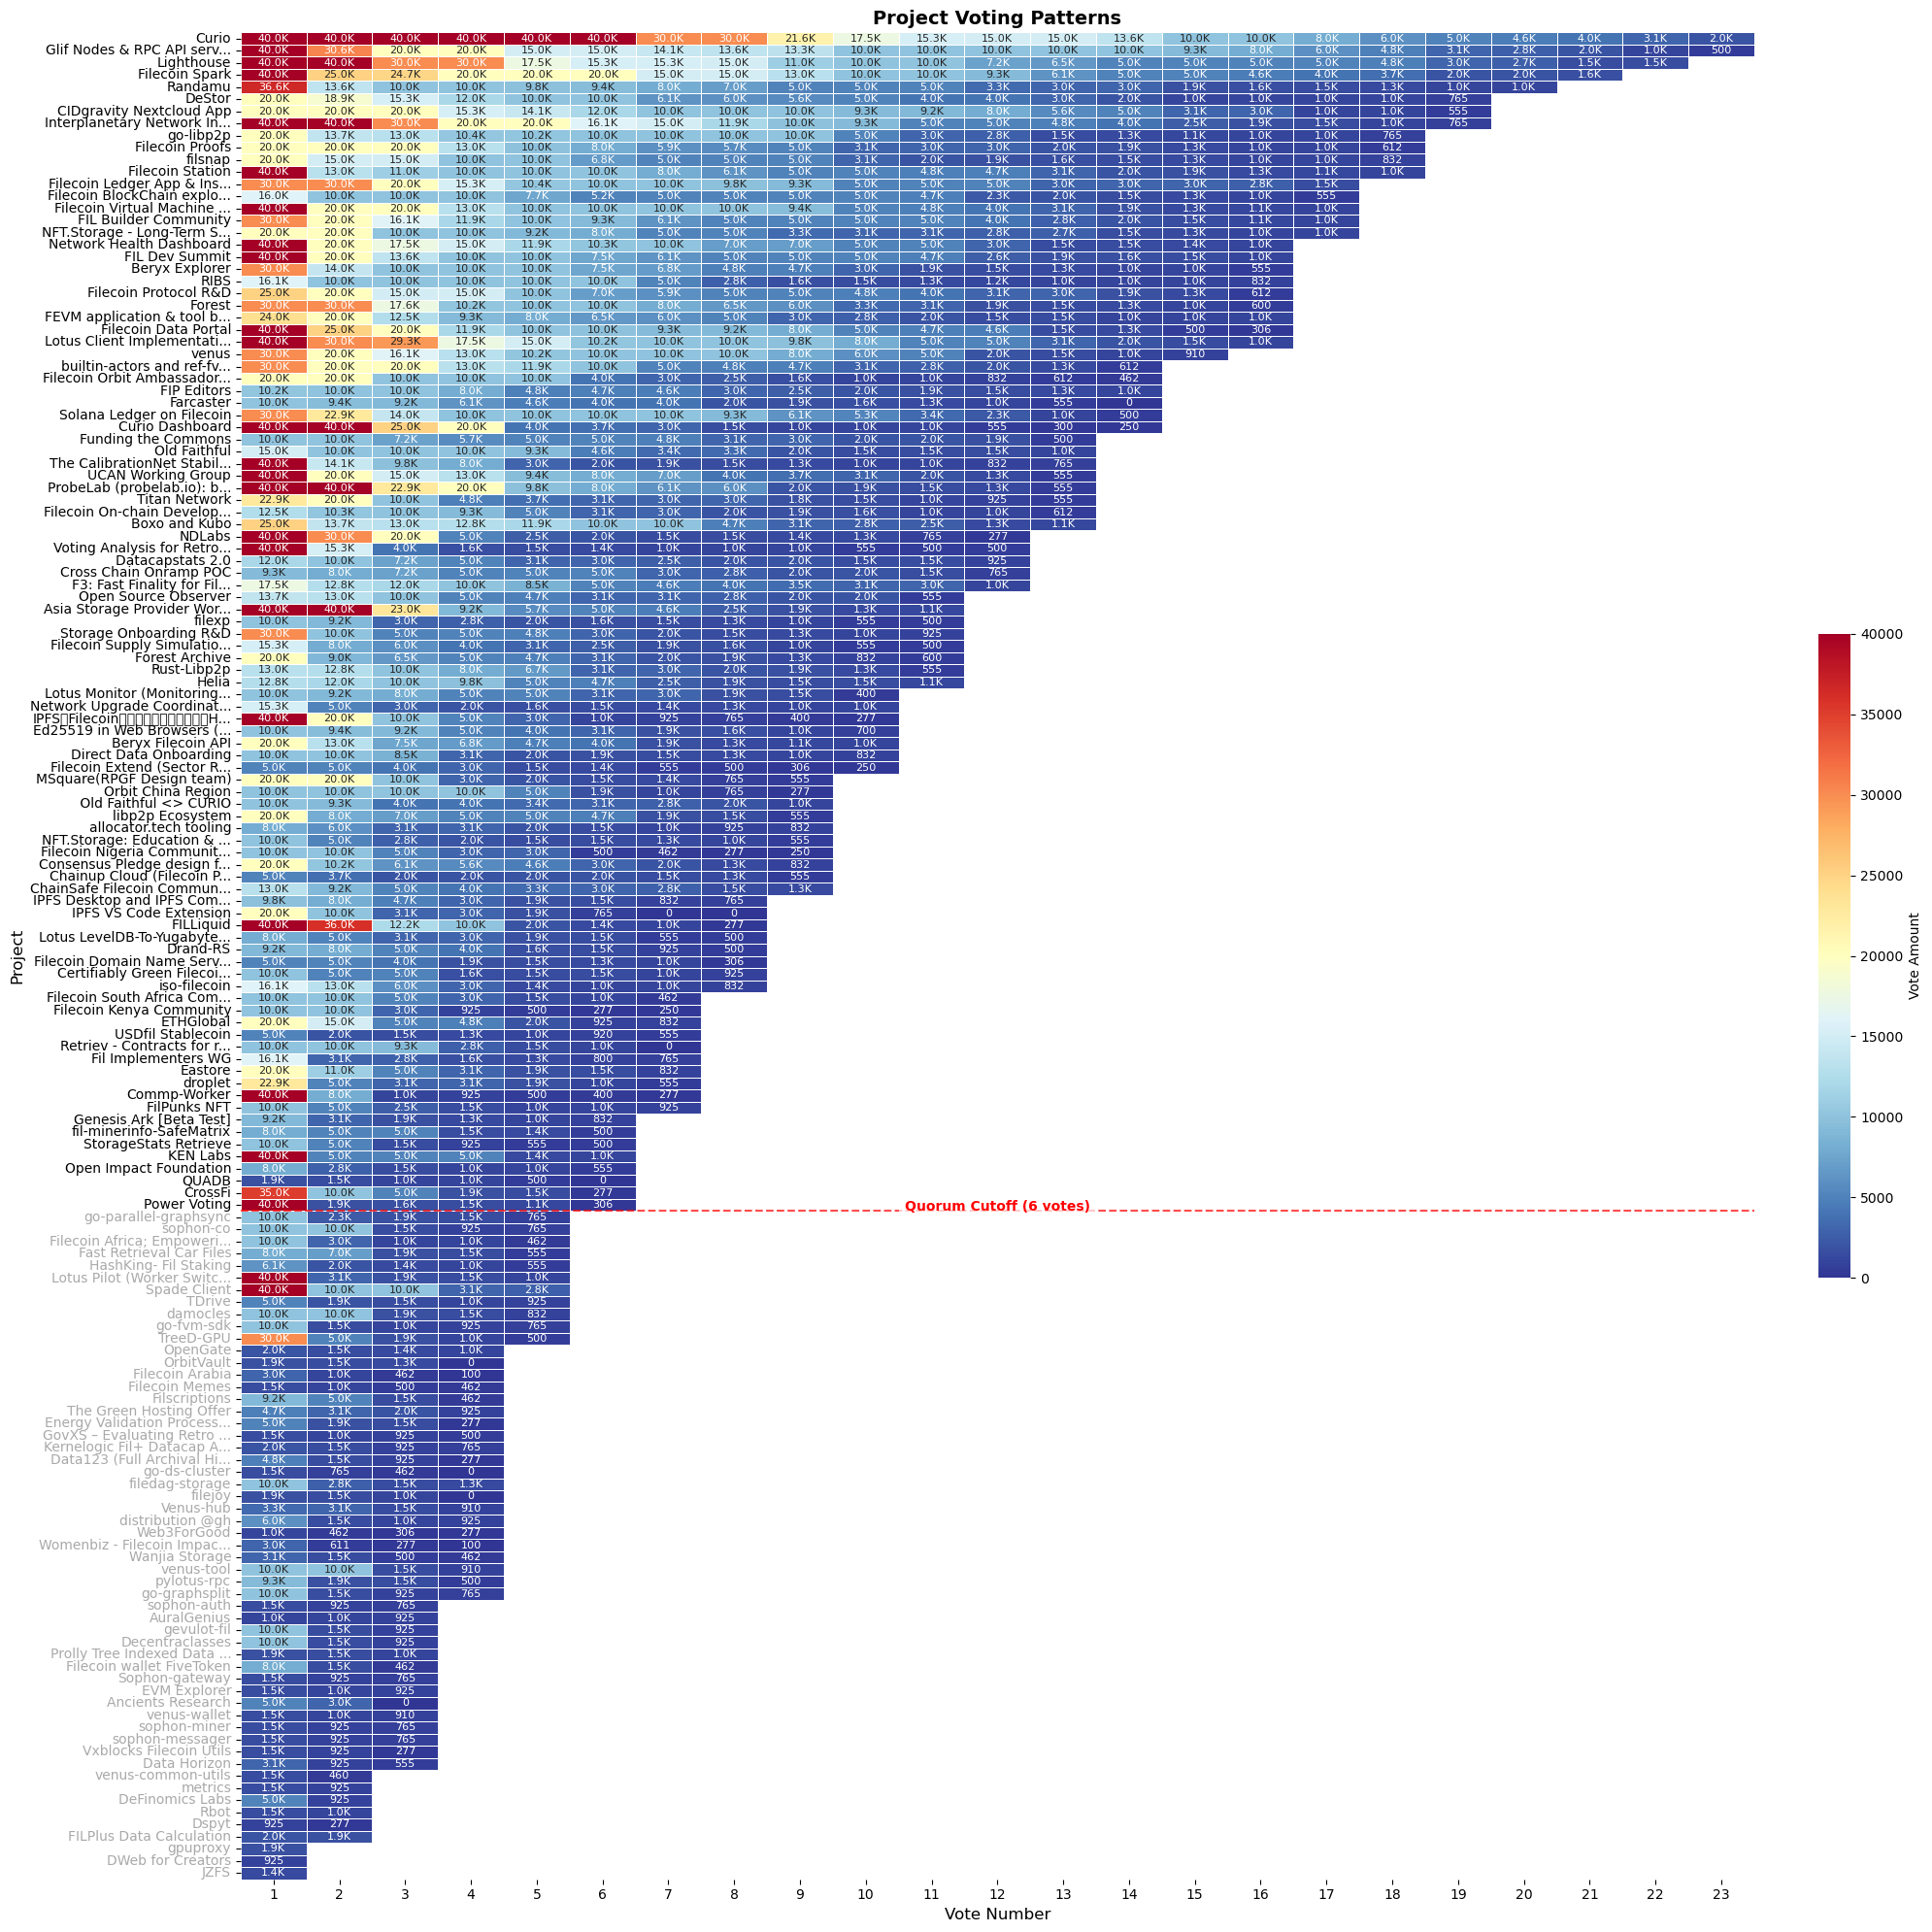

In [10]:
rpgf2lib.project_patterns_withname(dff, figsize=(20, 20), save_fp='../figures/project_patterns.png')

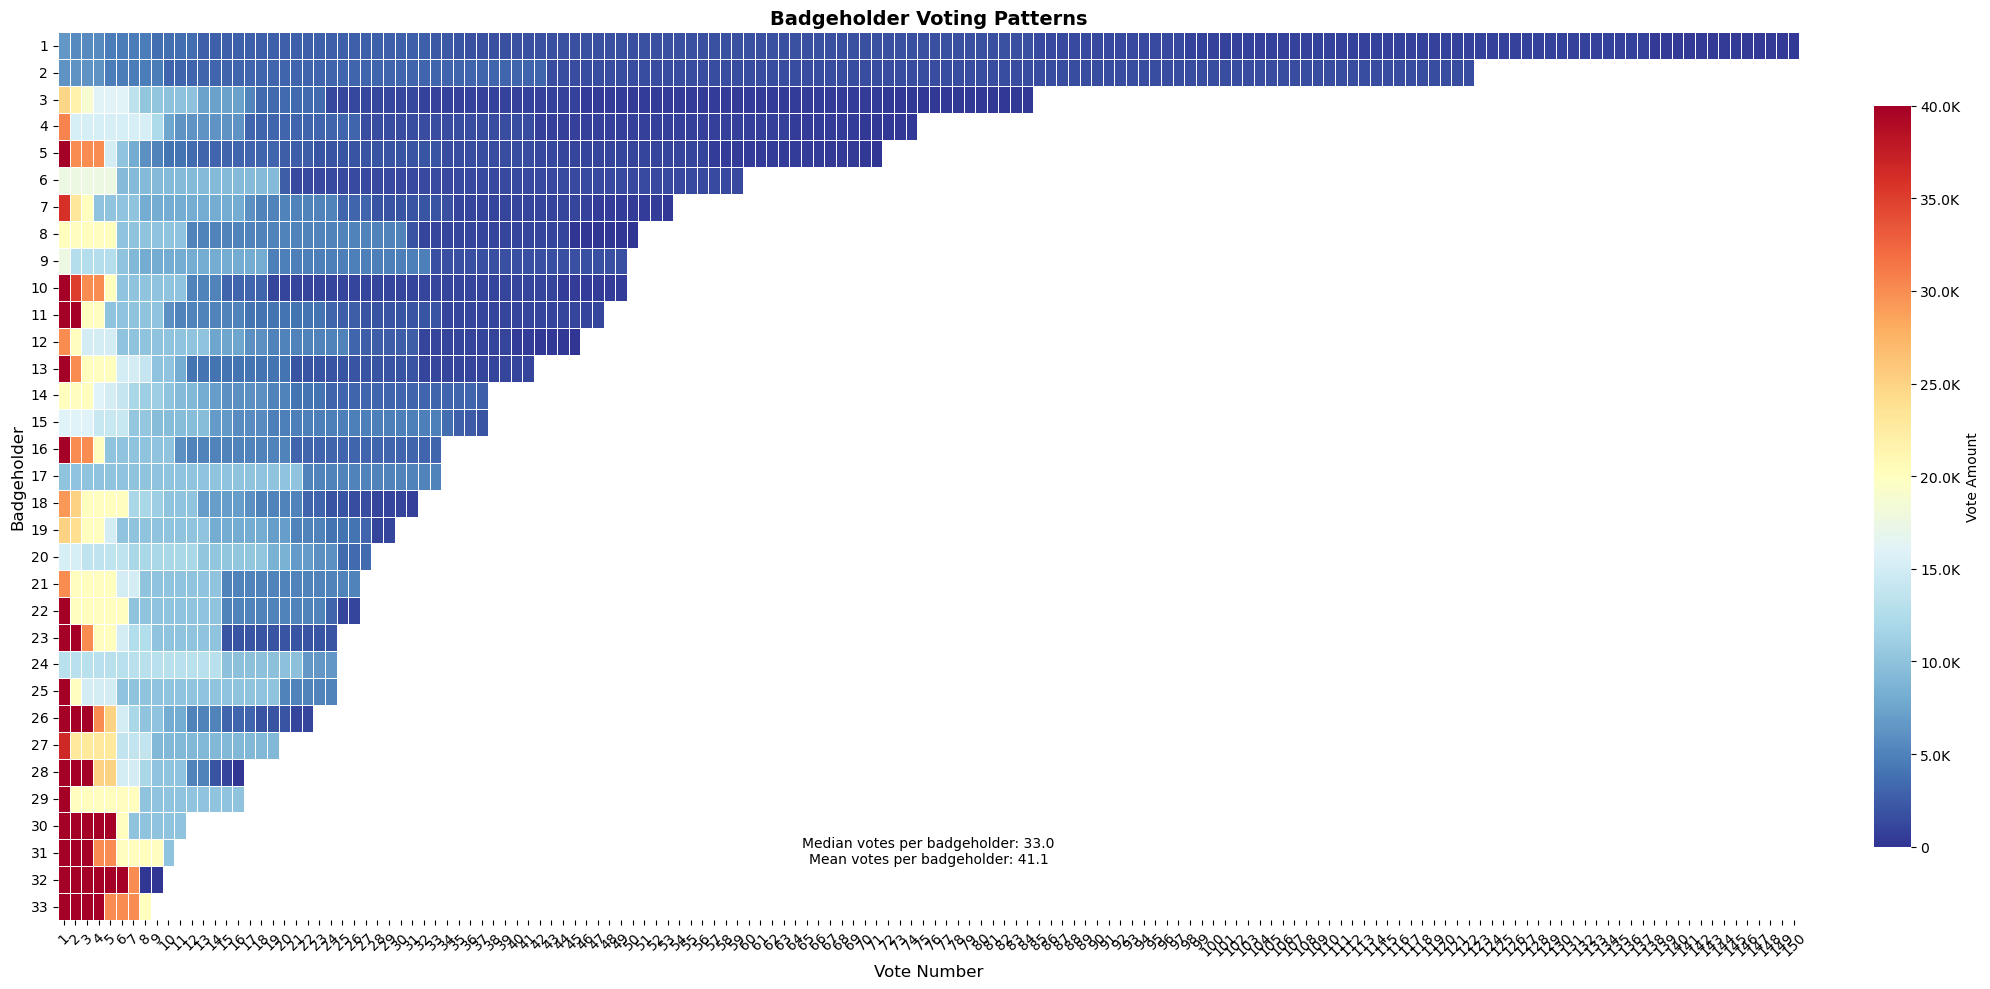

In [11]:
rpgf2lib.badgeholder_patterns2(dff, figsize=(20, 10), save_fp='../figures/badgeholder_patterns.png')

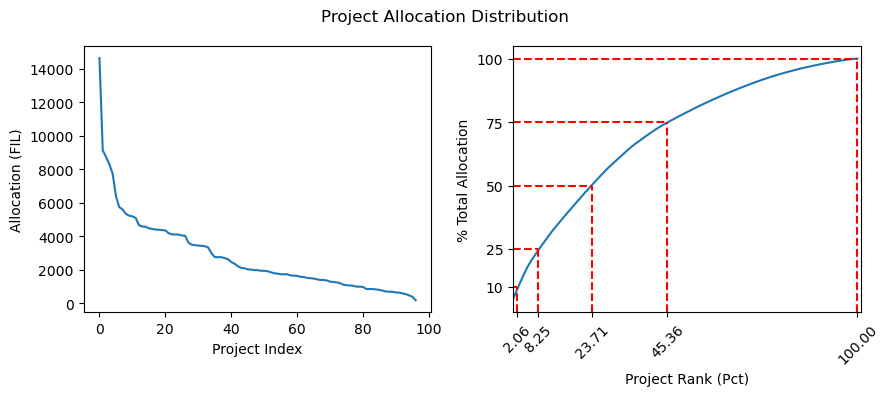

In [12]:
rpgf2lib.project_distribution_patterns(allocations, figsize=(9,4), save_fp='../figures/project_distribution.png')

In [13]:
upload_to_plotly = False

plotly_fig = rpgf2lib.plot_allocations_sunburst(success_df, 
                                                show_project_labels=True,
                                                save_fp='../figures/rpgf2_project_allocations.png')
plotly_fig.show()
if upload_to_plotly:
    with open(os.path.join(os.environ['HOME'], 'code', 'cel', 'auth', 'plotly.json'), 'r') as fp:
        plotly_auth = json.load(fp)
    chart_studio.tools.set_credentials_file(username=plotly_auth['username'], api_key=plotly_auth['api_key'])
    py.plot(plotly_fig, filename='rpgf2_project_allocations', auto_open=True)

Input DataFrame shape: (97, 6)
DataFrame columns: ['Project Name', 'Vote Count', 'Average Score', 'Std Dev', 'Final Allocation (FIL)', 'category']
Sample of input data:
                       Project Name  Vote Count  Average Score  Std Dev  \
46                            Curio          23       19595.59 14440.03   
41                       Lighthouse          22       12786.13 11874.83   
84     Glif Nodes & RPC API service          23       11694.56  9373.09   
58                   Filecoin Spark          21       12187.92  9921.58   
87  Interplanetary Network Indexers          19       12560.48 12506.66   

    Final Allocation (FIL)             category  
46                14645.92         Infra & Deps  
41                 9140.97  Tooling & Utilities  
84                 8740.62         Infra & Deps  
58                 8317.24         Protocol R&D  
87                 7755.15         Infra & Deps  
Project Name              0
Final Allocation (FIL)    0
category                

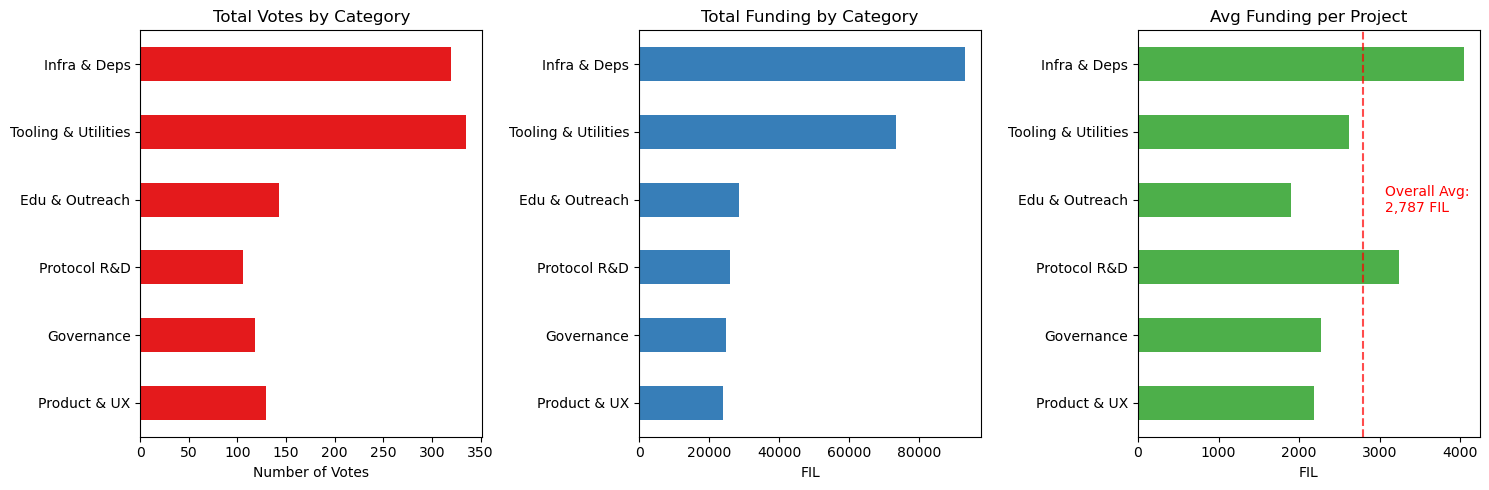

In [14]:
f = rpgf2lib.plot_category_metrics(
    success_df, 
    style='bar',
    save_fp='../figures/category_metrics.png'
)

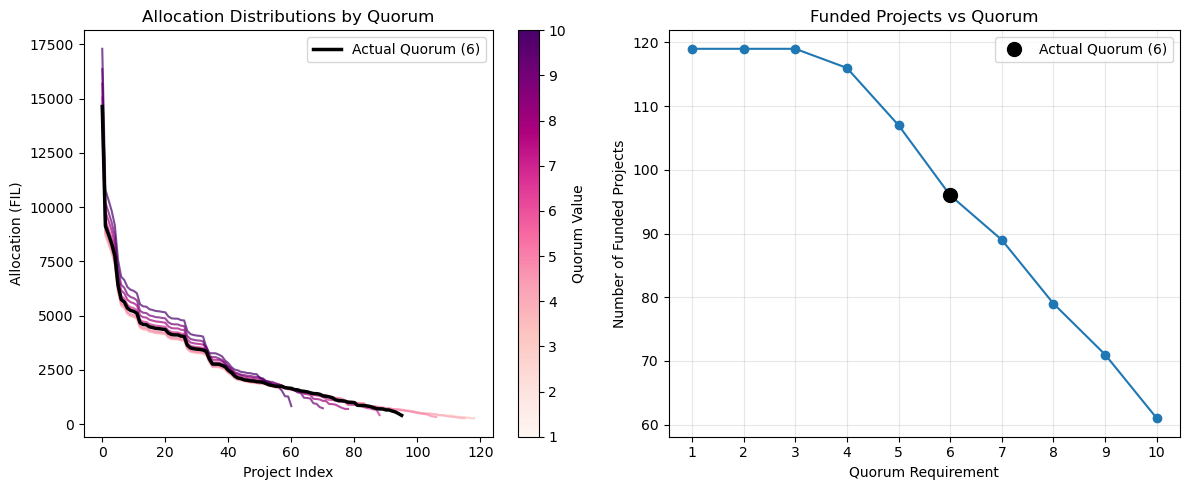

In [15]:
f = rpgf2lib.plot_quorum_sweep(df, save_fp='../figures/quorum_sweep.png')


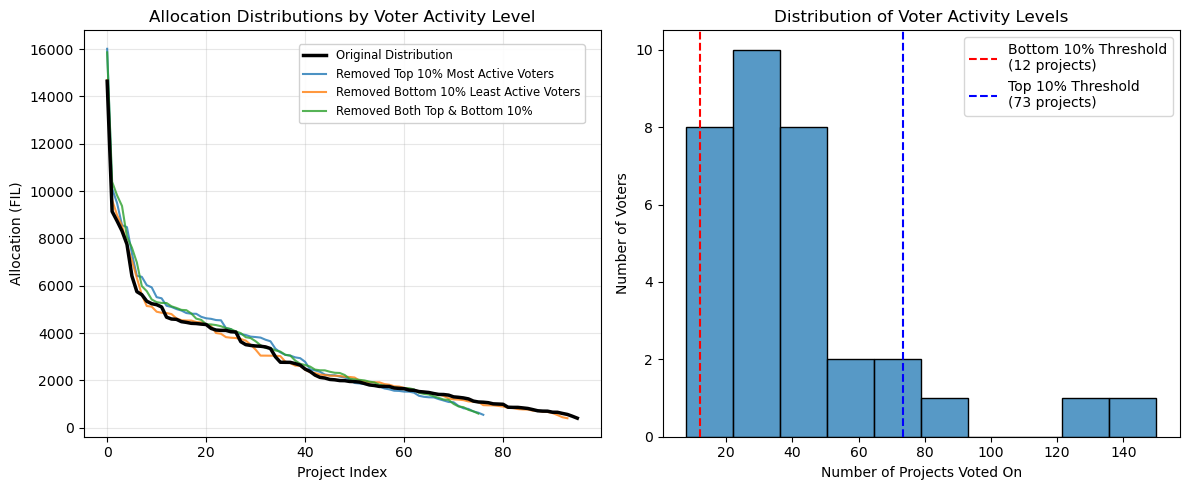

In [16]:
f = rpgf2lib.plot_temperature_analysis(df, save_fp='../figures/temperature_analysis.png')


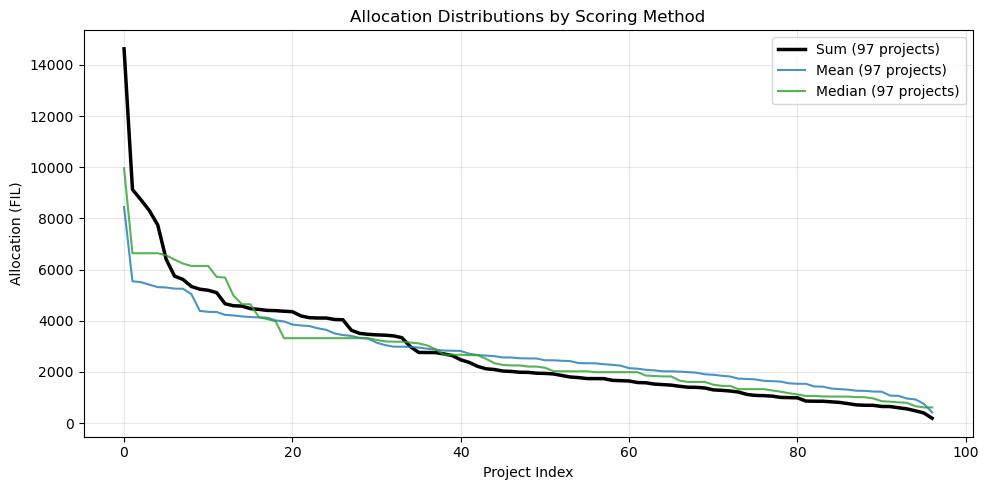

In [17]:
f = rpgf2lib.plot_scoring_comparison(df, save_fp='../figures/scoring_comparison.png')

In [18]:
bootstrap_allocations = rpgf2lib.bootstrap_allocation_distribution(
    df, 
    n_samples=1000,
    min_voters=28, 
    quorum_cutoff=6, 
    min_funding=250, 
    total_funding=270300, 
    sample_size=None  # choose between min_voters and total voters randomly
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
print(len(bootstrap_allocations))

1000


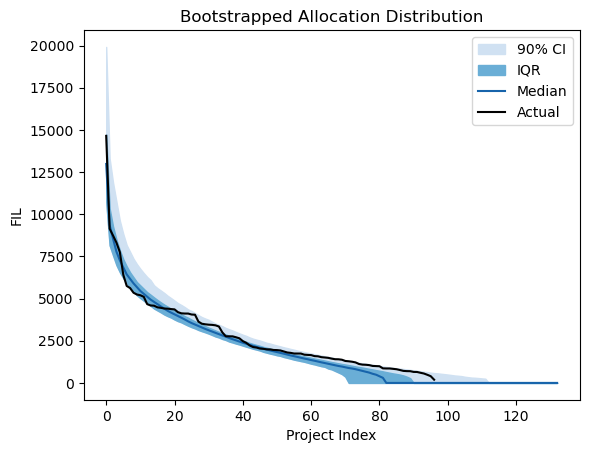

In [20]:
rpgf2lib.plot_bootstrap_distribution(
    bootstrap_allocations, 
    allocations, 
    save_fp='../figures/bootstrap_allocation_distribution.png'
)

In [21]:
success_df['PctOfTotal'] = success_df['Final Allocation (FIL)'] / success_df['Final Allocation (FIL)'].sum()*100
success_df.sort_values('PctOfTotal', ascending=False).head()
success_df.head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
46,Curio,23,19595.59,14440.03,14645.92,Infra & Deps,5.42
41,Lighthouse,22,12786.13,11874.83,9140.97,Tooling & Utilities,3.38
84,Glif Nodes & RPC API service,23,11694.56,9373.09,8740.62,Infra & Deps,3.23
58,Filecoin Spark,21,12187.92,9921.58,8317.24,Protocol R&D,3.08
87,Interplanetary Network Indexers,19,12560.48,12506.66,7755.15,Infra & Deps,2.87


In [22]:
xx = success_df.head()
xx['PctOfTotal'].sum()

17.979981494886406

In [23]:
success_df['Final Allocation (FIL)'].describe()


count      97.00
mean     2786.60
std      2281.49
min       190.91
25%      1256.50
50%      1986.50
75%      4112.09
max     14645.92
Name: Final Allocation (FIL), dtype: float64

In [24]:
success_df['Final Allocation (FIL)'].median()

1986.497663091053

In [25]:
success_df.sort_values('Vote Count', ascending=False).head()

,Project Name,Vote Count,Average Score,Std Dev,Final Allocation (FIL),category,PctOfTotal
46,Curio,23,19595.59,14440.03,14645.92,Infra & Deps,5.42
84,Glif Nodes & RPC API service,23,11694.56,9373.09,8740.62,Infra & Deps,3.23
41,Lighthouse,22,12786.13,11874.83,9140.97,Tooling & Utilities,3.38
58,Filecoin Spark,21,12187.92,9921.58,8317.24,Protocol R&D,3.08
14,Randamu,20,6848.65,7946.15,4451.08,Infra & Deps,1.65


In [26]:
position_analysis_df = success_df[['Project Name', 'Vote Count', 'Final Allocation (FIL)']]
position_analysis_df['projects_alphabet_pos'] = position_analysis_df['Project Name'].apply(lambda x: ord(x.strip()[0].lower()) - ord('a'))

/tmp/ipykernel_235550/1574748377.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [27]:
def correlation_model_votes(x, y):
    # Priors for means and standard deviations of x and y
    mu_x = numpyro.sample('mu_x', dist.Normal(0, 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    mu_y = numpyro.sample('mu_y', dist.Normal(0, 10))
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1))
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

def correlation_model_allocation(x, y):
    # Adjust priors to match the scale of the data
    mu_x = numpyro.sample('mu_x', dist.Normal(np.mean(x), 10))
    sigma_x = numpyro.sample('sigma_x', dist.Exponential(1))
    
    # Use more appropriate priors for y given the scale of allocations
    mu_y = numpyro.sample('mu_y', dist.Normal(np.mean(y), 1000))  # Increased scale
    sigma_y = numpyro.sample('sigma_y', dist.Exponential(1000))  # Increased scale
    
    # Prior for the correlation coefficient
    rho = numpyro.sample('rho', dist.Uniform(-1, 1))
    
    # Covariance matrix
    covariance = jnp.array([
        [sigma_x**2, rho * sigma_x * sigma_y],
        [rho * sigma_x * sigma_y, sigma_y**2]
    ])
    
    # Sampling from a bivariate normal distribution
    numpyro.sample('obs', dist.MultivariateNormal(loc=jnp.array([mu_x, mu_y]), covariance_matrix=covariance), obs=jnp.column_stack((x, y)))

In [28]:
nuts_kernel = NUTS(correlation_model_votes)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y1_data))

# mcmc.print_summary()
posterior_samples_votes = mcmc.get_samples()
rho_samples_votes = posterior_samples_votes['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_votes):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_votes,5):.2f} and {np.percentile(rho_samples_votes,95):.2f}")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1357.10it/s, 3 steps of size 8.17e-01. acc. prob=0.88]

Modelled Pearson correlation coefficient of -0.06
With 95% credible intervals of the correlation coefficient being between -0.22 and 0.09


In [29]:
nuts_kernel = NUTS(correlation_model_allocation)
n_samples = 1000
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=n_samples)

# Run MCMC
rng_key = random.PRNGKey(0)
x_data = position_analysis_df['projects_alphabet_pos'].values
y2_data = position_analysis_df['Final Allocation (FIL)'].values  # Use unsorted Vote Count
mcmc.run(rng_key, x=jnp.array(x_data), y=jnp.array(y2_data))

# mcmc.print_summary()
posterior_samples_funding = mcmc.get_samples()
rho_samples_funding = posterior_samples_funding['rho']

print(f"Modelled Pearson correlation coefficient of {np.mean(rho_samples_funding):.2f}")
print(f"With 95% credible intervals of the correlation coefficient being between {np.percentile(rho_samples_funding,5):.2f} and {np.percentile(rho_samples_funding,95):.2f}")

sample: 100%|██████████| 1500/1500 [00:01<00:00, 1240.05it/s, 7 steps of size 3.75e-01. acc. prob=0.93]

Modelled Pearson correlation coefficient of -0.00
With 95% credible intervals of the correlation coefficient being between -0.01 and 0.00


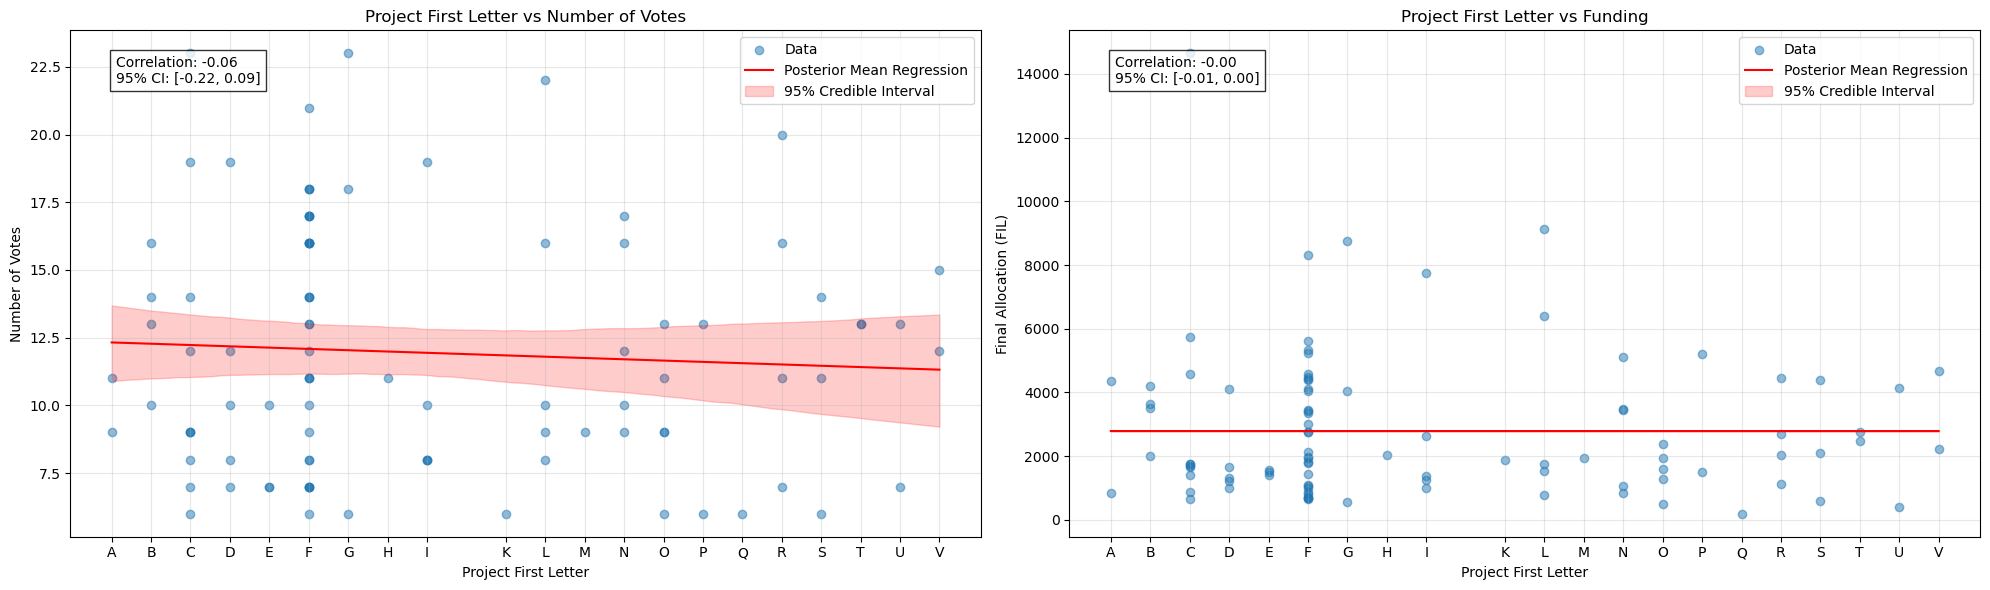

In [30]:
# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Create letter labels for x-axis
unique_positions = sorted(position_analysis_df['projects_alphabet_pos'].unique())
letter_labels = [chr(int(pos) + ord('A')) for pos in unique_positions]

# Left plot - Votes
x_data = position_analysis_df['projects_alphabet_pos'].values
y1_data = position_analysis_df['Vote Count'].values

# Generate lines for votes plot
x_line = np.linspace(min(x_data), max(x_data), 100)
y1_lines = []
for i in range(n_samples):
    rho = posterior_samples_votes['rho'][i]
    mu_x = posterior_samples_votes['mu_x'][i]
    mu_y = posterior_samples_votes['mu_y'][i]
    sigma_x = posterior_samples_votes['sigma_x'][i]
    sigma_y = posterior_samples_votes['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y1_lines.append(y)

y1_lines = np.array(y1_lines)
y1_mean = np.mean(y1_lines, axis=0)
y1_lower = np.percentile(y1_lines, 2.5, axis=0)
y1_upper = np.percentile(y1_lines, 97.5, axis=0)

# Plot votes
ax1.scatter(x_data, y1_data, alpha=0.5, label='Data')
ax1.plot(x_line, y1_mean, color='red', label='Posterior Mean Regression')
ax1.fill_between(x_line, y1_lower, y1_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_votes['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_votes['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_votes['rho'],95):.2f}]")
ax1.text(0.05, 0.95, correlation_text, transform=ax1.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax1.set_xticks(unique_positions)
ax1.set_xticklabels(letter_labels)
ax1.set_xlabel('Project First Letter')
ax1.set_ylabel('Number of Votes')
ax1.set_title('Project First Letter vs Number of Votes')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot - Funding
y2_data = position_analysis_df['Final Allocation (FIL)'].values

# Generate lines for funding plot
y2_lines = []
for i in range(n_samples):
    rho = posterior_samples_funding['rho'][i]
    mu_x = posterior_samples_funding['mu_x'][i]
    mu_y = posterior_samples_funding['mu_y'][i]
    sigma_x = posterior_samples_funding['sigma_x'][i]
    sigma_y = posterior_samples_funding['sigma_y'][i]
    
    beta = rho * sigma_y / sigma_x
    y = mu_y + beta * (x_line - mu_x)
    y2_lines.append(y)

y2_lines = np.array(y2_lines)
y2_mean = np.mean(y2_lines, axis=0)
y2_lower = np.percentile(y2_lines, 2.5, axis=0)
y2_upper = np.percentile(y2_lines, 97.5, axis=0)

# Plot funding
ax2.scatter(x_data, y2_data, alpha=0.5, label='Data')
ax2.plot(x_line, y2_mean, color='red', label='Posterior Mean Regression')
ax2.fill_between(x_line, y2_lower, y2_upper, color='red', alpha=0.2, label='95% Credible Interval')

correlation_text = (f"Correlation: {np.mean(posterior_samples_funding['rho']):.2f}\n"
                   f"95% CI: [{np.percentile(posterior_samples_funding['rho'],5):.2f}, "
                   f"{np.percentile(posterior_samples_funding['rho'],95):.2f}]")
ax2.text(0.05, 0.95, correlation_text, transform=ax2.transAxes, 
         bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')

ax2.set_xticks(unique_positions)
ax2.set_xticklabels(letter_labels)
ax2.set_xlabel('Project First Letter')
ax2.set_ylabel('Final Allocation (FIL)')
ax2.set_title('Project First Letter vs Funding')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('../figures/project_letter_vs_votes_and_funding.png', dpi=300)

#### Some information to compare R1 to R2

In [31]:
round1_df = pd.read_csv('../data/round1_results.csv')
round1_df = round1_df[round1_df['Quorum reached'] == True]
round1projects = round1_df['Project Name'].str.strip().str.lower().unique()

In [32]:
from thefuzz import process  # or from fuzzywuzzy import process

def find_project_matches(project_name, success_df, failed_df, threshold=80):
    success_projects = success_df[['Project Name', 'Final Allocation (FIL)']].copy()
    success_projects['status'] = 'SUCCESS'
    
    failed_projects = failed_df[['Project Name', 'Vote Count']].copy()
    failed_projects['Final Allocation (FIL)'] = 0
    failed_projects['status'] = 'FAILED'
    
    success_projects['name_lower'] = success_projects['Project Name'].str.strip().str.lower()
    failed_projects['name_lower'] = failed_projects['Project Name'].str.strip().str.lower()
    
    all_projects = pd.concat([success_projects['name_lower'], 
                            failed_projects['name_lower']]).unique()
    
    # Find the best match
    matches = process.extract(project_name.lower(), all_projects, limit=1)
    
    if matches[0][1] > threshold:
        matched_name = matches[0][0]
        # Check which dataframe contains the match and get details
        if matched_name in success_projects['name_lower'].values:
            project_details = success_projects[success_projects['name_lower'] == matched_name].iloc[0]
            return {
                'original_name': project_name,
                'matched_name': project_details['Project Name'],
                'status': 'Received Funding in Round 2',
                'allocation': project_details['Final Allocation (FIL)'],
                'match_score': matches[0][1]
            }
        else:
            project_details = failed_projects[failed_projects['name_lower'] == matched_name].iloc[0]
            return {
                'original_name': project_name,
                'matched_name': project_details['Project Name'],
                'status': 'Did not receive funding in Round 2',
                'allocation': 0,
                'match_score': matches[0][1]
            }
    
    return {
        'original_name': project_name,
        'matched_name': matches[0][0],
        'status': 'NOT IN ROUND 2',
        'allocation': 0,
        'match_score': matches[0][1]
    }

In [33]:
results = []
for p in round1projects:
    match = find_project_matches(p, success_df, failed_df)
    results.append(match)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

In [34]:
round1_round2_overlap_df = results_df[results_df['status'] != 'NOT IN ROUND 2']
len(round1_round2_overlap_df)

77

In [35]:
round1_round2_overlap_df['allocation'].sum()

248923.93466977944

In [36]:
print(len(round1_round2_overlap_df[round1_round2_overlap_df['allocation'] == 0]))
print(len(round1_round2_overlap_df[round1_round2_overlap_df['allocation'] > 0]))

17
60
